# Conditional Variational Auto Encoder (CVAE)

I am going to create my own CVAE, and I am going to use the mnist dataset to show it's learning

## Import the data and tensorflow

In [1]:
# Import numpy and Pandas

import numpy as np
import matplotlib.pyplot as plt

# import the data
from tensorflow import keras
from keras.datasets import mnist

# import TensorFlow, and neural network stuff 

import tensorflow as tf
from tensorflow.keras import layers, losses, models, Model, ops, Input

## Print out the Images

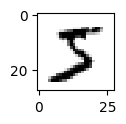

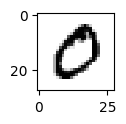

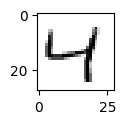

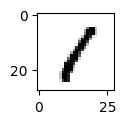

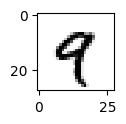

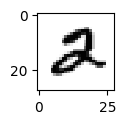

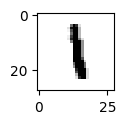

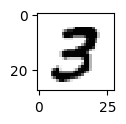

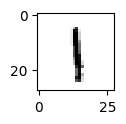

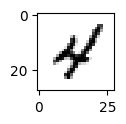

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist_data=x_train
#Normilize the data 
mnist_data=mnist_data/255.0

for i in range(10):
    plt.figure(1, figsize=(1,1))
    plt.imshow(mnist_data[i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.show()

## Here is the original VAE I worked on constructing

### Here is the VAE subclass that takes into account:

1) The modification of the train step function
2) using both the encoder and the decoder
3) using both KL divergence and MSE for loss function

In [32]:
# This code is from citation 2
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
             )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.001 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


### Here is the sampling class we use to get a sample from a normal distribution

In [33]:
# This code is from citation 2)
class Sampling(layers.Layer):
    "Allows us to sample from a Gaussian Distribution"
    def call(self, inputs):
        z_mean, z_log_var = inputs
        print(z_mean)
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

### VAE class

In [34]:
class Var_AutoEncoder:
    encoder = ""
    decoder = ""
    autoEncoder = ""
    shapeOfImage = 0
    history = ""
    flattened=""
    input_size=""
    latent_dim=""
    recon=[]
    
    def __init__(self, shapeOfImage, flattened=False, latent_dim=2):
        '''This is how we initialize our Auto encoder. Can choose to input numOfHiddenLayers, optimizerChoice, lossChoice'''
        self.flattened= flattened
        self.shapeOfImage = shapeOfImage
        self.latent_dim=latent_dim
        
    def constructModel(self, numOfHiddenLayers=3, optimizerChoice="adam", lossChoice=losses.MeanSquaredError(), activationChoice="relu"):
        '''Here we create the encoder, the decoder, and the full auto encoder. We also compile the entire autoencoder'''

        #Make the encoder, get the size of the bottleNeck to use for making the decoder
        self.encoder, bottleNeck = self.createEncoderNetwork(numOfHiddenLayers, activationChoice)

        self.encoder.summary()

        #make the decoder model, using the bottleNeck size
        self.decoder = self.createDecoderNetwork(numOfHiddenLayers, bottleNeck, activationChoice)

        self.decoder.summary()
        
        # Pass the sampled latent vector (z) from the encoder to the decoder
        encoder_inputs = self.encoder.input  # Input layer of the encoder
        z_mean, z_log_var, z = self.encoder.output        # Output of the encoder (z_mean, z_log_var, z)
        decoder_outputs = self.decoder(z)    # Decoder output for the sampled latent vector
    
        # Build the autoencoder
        self.autoEncoder = Model(inputs=encoder_inputs, outputs=decoder_outputs, name="autoEncoder")
    
        # Compile the autoencoder
        self.autoEncoder.compile(optimizer=optimizerChoice, loss=lossChoice)
        print("AutoEncoder successfully created and compiled.")
        return

    def getModels(self):
        return self.encoder, self.decoder

    def variation_loss(inputs, reconstruction, z_mean, z_log_var):
        reconstruction_loss = layers.backend.mean(layers.backend.sum(layers.backend.square(inputs - reconstruction), axis = 1))

        kl_loss = -0.8 * layers.backend.mean(layers.backend.sum(1 + z_log_var - layers.backend.square(z_mean)-layers.backend.exp(z_log_var), axis=1))
        
        return reconstruction_loss + kl_loss
    
    def createEncoderNetwork(self, numOfHiddenLayers, activationChoice='relu'):
        '''Here is where we construct our nerual network that takes
        in an image from the dataset, and gives us an output for our
        "bottleneck".'''
    
        #neuralNetwork = models.Sequential()
        
        if self.flattened:
            encoder_inputs = Input(shape=(self.shapeOfImage,))
            x = (layers.Dense(self.shapeOfImage, activation=activationChoice, input_shape=(self.shapeOfImage,)))(encoder_inputs)
            self.input_size=self.shapeOfImage
            
        else:
            encoder_inputs = Input(shape=(self.shapeOfImage))
            x = layers.Flatten()(encoder_inputs)
            x = (layers.Dense(self.shapeOfImage[0]*self.shapeOfImage[1], activation=activationChoice, input_shape=(self.shapeOfImage)))(x)
            self.input_size=self.shapeOfImage[0]*self.shapeOfImage[1]
            
        for i in range(numOfHiddenLayers):
            x = (layers.Dense(int(self.input_size/(2 ** (i+1))), activation=activationChoice))(x)
    
        bottleNeckSize = (int(self.input_size/(2 **(numOfHiddenLayers+1))))
        
        self.bottleNeckSize=bottleNeckSize
        
        x = (layers.Dense(bottleNeckSize, activation=activationChoice))(x)

        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        
        z = Sampling()([z_mean, z_log_var])
        
        return Model(encoder_inputs, [z_mean, z_log_var,z], name="encoder"), bottleNeckSize
        
    def createDecoderNetwork(self, numOfHiddenLayers, bottleNeckSize, activationChoice='relu'):
        '''Here is where we construct our nerual network that takes
        in our output from the bottleneck found by our encoder, and
        gives us an image as an output'''
    
        # neuralNetwork = models.Sequential()

        decoder_inputs = (Input(shape=(self.latent_dim,)))

        x = (layers.Dense(self.latent_dim, activation=activationChoice, input_shape=(self.latent_dim,)))(decoder_inputs)
    
        for i in range(numOfHiddenLayers):
            print(f"Hidden layer {i} size is :{int(bottleNeckSize*(2 ** (i+1)))}")
            x = (layers.Dense(int(bottleNeckSize*(2 ** (i+1))), activation=activationChoice))(x)
        x = layers.Dense(self.shapeOfImage[0] * self.shapeOfImage[1], activation=activationChoice)(x)
        decoder_outputs = layers.Dense(self.input_size, activation=activationChoice)(x)

        if not self.flattened:
            x = layers.Reshape((self.shapeOfImage[0], self.shapeOfImage[1], 1))(x)  # Include channel dimension

        # Transposed convolution to generate the final output
        decoder_outputs = layers.Conv2DTranspose(
            1, 3, activation="sigmoid", padding="same", name="final_output")(x)
        
        decoder = Model(decoder_inputs, decoder_outputs, name="decoder")
        print("Decoder created:", decoder)  # Debugging output
        return decoder

    def getEncoderDecoderSummaries(self):
        self.encoder.summary()
        self.decoder.summary()
        return

    def getNetworkSummary(self):
        self.autoEncoder.summary()

    def train(self, data, numEpochs=10, batchSize=128):
        self.history = self.autoEncoder.fit(data, data, epochs=numEpochs, batch_size=batchSize, verbose=0)
        return self.history

    def compareInputOutput(self, inputImage):
        print("\nInput Image:\n")
        if self.flattened:
            # Make a plot of the input image
            plt.figure(1, figsize=(1,1))
            plt.imshow(np.reshape(inputImage, (8,8)), cmap=plt.cm.gray_r, interpolation="nearest")
            plt.show()
    
            # Reformat the image data
            inputData = np.expand_dims(inputImage, axis=0)
    
            # Get the outputing image data
            picture = self.autoEncoder.predict(inputData)
    
            # Reshape the output so it works with the plot
            reconstructedImage = np.reshape(picture, (8, 8))
            
        else:
            plt.figure(1, figsize=(1,1))
            plt.imshow(inputImage, cmap=plt.cm.gray_r, interpolation="nearest")
            plt.show()
            inputData = np.expand_dims(inputImage, axis=0)
            reconstructedImage= np.reshape(self.autoEncoder.predict(inputData), self.shapeOfImage)
    
        print("\nOutput Image:\n")

        #make a plot of the output image
        plt.figure(1, figsize=(1,1))
        plt.imshow(reconstructedImage, cmap=plt.cm.gray_r, interpolation="nearest")
        plt.show()

        self.recon.append(np.mean((inputImage - reconstructedImage) ** 2))

    def get_recon(self):
        if self.recon==[]:
            print("This list is empty run compareInputOutput to get values")
        return self.recon

    def reset_recon(self):
        self.recon=[]

    def predict(self, inputImage):
        if self.flattened:
            inputData = np.expand_dims(inputImage, axis=0)
            picture = self.autoEncoder.predict(inputData)
            reconstructedImage = np.reshape(picture, (8, 8))
            
        else:
            inputData = np.expand_dims(inputImage, axis=0)
            reconstructedImage= np.reshape(self.autoEncoder.predict(inputData), self.shapeOfImage)
        return reconstructedImage


### Initialize and construct the model

In [35]:
var_autoEncoder = Var_AutoEncoder((28,28), flattened=False, latent_dim=16)
var_autoEncoder.constructModel(numOfHiddenLayers=3)

Tensor("Placeholder:0", shape=(None, 16), dtype=float32)


c:\Users\20mat\personalProjects\AutoEncoder\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 784)       │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 784)       │    615,440 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 392)       │    307,720 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 196)       │     77,028 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 98)        │     19,306 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 49)        │      4,851 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        800 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        800 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 16)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,025,945 (3.91 MB)

 Trainable params: 1,025,945 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

Hidden layer 0 size is :98
Hidden layer 1 size is :196
Hidden layer 2 size is :392
Decoder created: <Functional name=decoder, built=True>


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 98)             │         1,666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 196)            │        19,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 392)            │        77,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 784)            │       308,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_output (Conv2DTranspose)  │ (None, 28, 28, 1)      │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,688 (1.55 MB)

 Trainable params: 406,688 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

AutoEncoder successfully created and compiled.


### Compile the model and train

In [36]:
encoder, decoder = var_autoEncoder.getModels()

#This code is from citation 2)
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
Tensor("encoder_1/z_mean_1/BiasAdd:0", shape=(None, 16), dtype=float32)
Tensor("encoder_1/z_mean_1/BiasAdd:0", shape=(None, 16), dtype=float32)
547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - kl_loss: 151.1188 - loss: 205.8000 - reconstruction_loss: 205.6489
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - kl_loss: 276.7094 - loss: 132.0242 - reconstruction_loss: 131.7475
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 294.2639 - loss: 112.7600 - reconstruction_loss: 112.4658
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 280.6044 - loss: 103.6299 - reconstruction_loss: 103.3493
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 266.0504 - loss: 97.8853 - reconstruction_loss: 97.6192
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 256.1173 - loss: 92.7237 - reconstruction_loss: 92.4676
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 241.3223 - loss: 89.2241 - reconstruction_loss: 88.9828
E

### Compare the input and the output


Input Image:



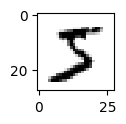

Tensor("autoEncoder_1/z_mean_1/BiasAdd:0", shape=(1, 16), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step

Output Image:



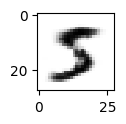


Input Image:



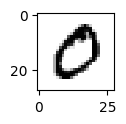

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Output Image:



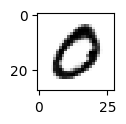


Input Image:



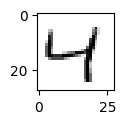

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Output Image:



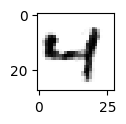


Input Image:



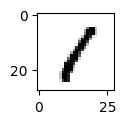

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Output Image:



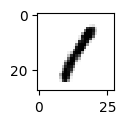


Input Image:



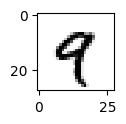

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Output Image:



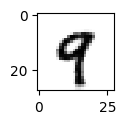


Input Image:



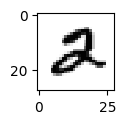

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Output Image:



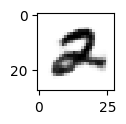


Input Image:



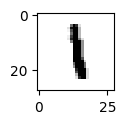

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Output Image:



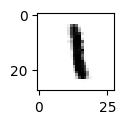


Input Image:



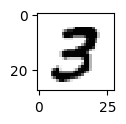

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Output Image:



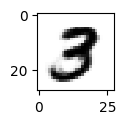


Input Image:



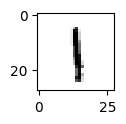

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Output Image:



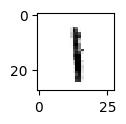


Input Image:



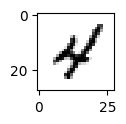

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Output Image:



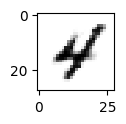

In [37]:
for i in range(10):
    var_autoEncoder.compareInputOutput(mnist_digits[i])

### Citations:

1) Building Autoencoders in Keras:
   https://blog.keras.io/building-autoencoders-in-keras.html

2) Variational AutoEncoder:
   https://keras.io/examples/generative/vae/

3) Stack Overflow
   https://stackoverflow.com/questions/51202181/how-do-i-select-only-a-specific-digit-from-the-mnist-dataset-provided-by-keras

# Here Is the making of the CVAE

The main changes we need to include are first, letting the model both take in the image, and the label. When we create the decoder, we also have to make the model take in the input. 

In [9]:
# This code is from citation 2, but is also modified
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    @tf.function
    def train_step(self, data):
        images, labels = data  # Unpack the data and labels
        
        with tf.GradientTape() as tape:
            # Encode with both image and label
            z_mean, z_log_var, z = self.encoder([images, labels])
            
            # Decode with both latent space and label
            reconstruction = self.decoder([z, labels])
            
            # Compute losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(images, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = 0.001 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))  # Added beta weight
            total_loss = reconstruction_loss + kl_loss

        # Update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    # Need a new call function in order to make sure that we are taking in both the image and the label
    def call(self, inputs):
        images, labels = inputs
        # First get latent representation from encoder
        z_mean, z_log_var, z = self.encoder([images, labels])
        # Then pass latent representation and labels to decoder
        return self.decoder([z, labels])



In [10]:
# This code is from citation 2)
class Sampling(layers.Layer):
    "Allows us to sample from a Gaussian Distribution"
    def call(self, inputs):
        z_mean, z_log_var = inputs
        print(z_mean)
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [11]:
class Conditional_Var_AutoEncoder:
    encoder = ""
    decoder = ""
    autoEncoder = ""
    shapeOfImage = 0
    labelSize = 0
    history = ""
    flattened=""
    input_size=""
    latent_dim=""
    recon=[]
    
    def __init__(self, shapeOfImage, labelSize, flattened=False, latent_dim=2):
        '''This is how we initialize our Auto encoder. Can choose to input numOfHiddenLayers, optimizerChoice, lossChoice'''
        self.flattened= flattened
        self.shapeOfImage = shapeOfImage
        self.latent_dim=latent_dim
        self.labelSize = labelSize
        
    def constructModel(self, numOfHiddenLayers=3, optimizerChoice="adam", lossChoice=losses.MeanSquaredError(), activationChoice="relu"):
        '''Here we create the encoder, the decoder, and the full auto encoder. We also compile the entire autoencoder'''

        #def constructModel(self, numOfHiddenLayers=3, optimizerChoice="adam", lossChoice=losses.MeanSquaredError(), activationChoice="relu"):
        self.encoder, bottleNeck = self.createEncoderNetwork(numOfHiddenLayers, activationChoice)
        self.decoder = self.createDecoderNetwork(numOfHiddenLayers, bottleNeck, activationChoice)
        
        # Define inputs
        img_input = Input(shape=self.shapeOfImage if not self.flattened else (self.shapeOfImage,))
        label_input = Input(shape=(self.labelSize,))
        
        # Get encoder outputs
        z_mean, z_log_var, z = self.encoder([img_input, label_input])
        
        # Get decoder output (pass both z and label)
        decoder_outputs = self.decoder([z, label_input])
        
        # Build the autoencoder with both inputs
        self.autoEncoder = Model(inputs=[img_input, label_input], outputs=decoder_outputs, name="autoEncoder")
        
        # Compile the autoencoder
        self.autoEncoder.compile(optimizer=optimizerChoice, loss=lossChoice)
        print("AutoEncoder successfully created and compiled.")

    def getModels(self):
        return self.encoder, self.decoder

    def variation_loss(inputs, reconstruction, z_mean, z_log_var):
        reconstruction_loss = layers.backend.mean(layers.backend.sum(layers.backend.square(inputs - reconstruction), axis = 1))

        kl_loss = -0.8 * layers.backend.mean(layers.backend.sum(1 + z_log_var - layers.backend.square(z_mean)-layers.backend.exp(z_log_var), axis=1))
        
        return reconstruction_loss + kl_loss
    
    def createEncoderNetwork(self, numOfHiddenLayers, activationChoice='relu'):
        '''Here is where we construct our nerual network that takes
        in an image from the dataset, and gives us an output for our
        "bottleneck".'''
        
        if self.flattened:
            img_input = Input(shape=(self.shapeOfImage,))
            label_input = Input(shape=(self.labelSize,))
            self.input_size = self.shapeOfImage
            # For flattened input, use img_input directly
            img_to_concat = img_input
        else:
            img_input = Input(shape=self.shapeOfImage)
            label_input = Input(shape=(self.labelSize,))
            # For unflattened input, we need to flatten it first
            img_flat = layers.Flatten()(img_input)
            self.input_size = self.shapeOfImage[0] * self.shapeOfImage[1]
            img_to_concat = img_flat
            
        # Concatenate image and label using the appropriate image tensor
        x = layers.Concatenate()([img_to_concat, label_input])
            
        x = layers.Dense(self.input_size + self.labelSize, activation=activationChoice)(x)
        
        for i in range(numOfHiddenLayers):
            x = (layers.Dense(int(self.input_size/(2 ** (i+1))), activation=activationChoice))(x)

        bottleNeckSize = (int(self.input_size/(2 **(numOfHiddenLayers+1))))
        self.bottleNeckSize = bottleNeckSize
        
        x = (layers.Dense(bottleNeckSize, activation=activationChoice))(x)

        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        
        z = Sampling()([z_mean, z_log_var])
        
        return Model([img_input, label_input], [z_mean, z_log_var, z], name="encoder"), bottleNeckSize

        
    def createDecoderNetwork(self, numOfHiddenLayers, bottleNeckSize, activationChoice='relu'):
        '''Here is where we construct our nerual network that takes
        in our output from the bottleneck found by our encoder, and
        gives us an image as an output'''

        latent_input = Input(shape=(self.latent_dim,))
        label_input = Input(shape=(self.labelSize,))
        
        # Concatenate latent vector and label
        x = layers.Concatenate()([latent_input, label_input])
        
        x = layers.Dense(self.latent_dim + self.labelSize, activation=activationChoice)(x)
        
        for i in range(numOfHiddenLayers):
            # print(f"Hidden layer {i} size is :{int(bottleNeckSize*(2 ** (i+1)))}")
            x = (layers.Dense(int(bottleNeckSize*(2 ** (i+1))), activation=activationChoice))(x)

        x = layers.Dense(self.shapeOfImage[0] * self.shapeOfImage[1], activation=activationChoice)(x)
        decoder_outputs = layers.Dense(self.input_size, activation=activationChoice)(x)

        if not self.flattened:
            x = layers.Reshape((self.shapeOfImage[0], self.shapeOfImage[1], 1))(x)
            # Transposed convolution to generate the final output
            decoder_outputs = layers.Conv2DTranspose(
                1, 3, activation="sigmoid", padding="same", name="final_output")(x)
        
        # Changed to include both inputs
        decoder = Model([latent_input, label_input], decoder_outputs, name="decoder")
        print("Decoder created:", decoder)
        return decoder

    def getEncoderDecoderSummaries(self):
        self.encoder.summary()
        self.decoder.summary()
        return

    def getNetworkSummary(self):
        self.autoEncoder.summary()

    def train(self, data, labels, numEpochs=10, batchSize=128):
        self.history = self.autoEncoder.fit(
            [data, labels],  # Input is now [images, labels]
            data,           # Output is still just the images
            epochs=numEpochs,
            batch_size=batchSize,
            verbose=0
        )
        return self.history

    def compareInputOutput(self, inputImage, label):
        print("\nInput Image:\n")
        if self.flattened:
            # Make a plot of the input image
            plt.figure(1, figsize=(1,1))
            plt.imshow(np.reshape(inputImage, (8,8)), cmap=plt.cm.gray_r, interpolation="nearest")
            plt.show()

            # Reformat the image and label data
            inputData = np.expand_dims(inputImage, axis=0)
            labelData = np.expand_dims(label, axis=0)

            # Get the output image data
            picture = self.autoEncoder.predict([inputData, labelData])

            # Reshape the output so it works with the plot
            reconstructedImage = np.reshape(picture, (8, 8))
            
        else:
            plt.figure(1, figsize=(1,1))
            plt.imshow(inputImage, cmap=plt.cm.gray_r, interpolation="nearest")
            plt.show()
            
            inputData = np.expand_dims(inputImage, axis=0)
            labelData = np.expand_dims(label, axis=0)
            reconstructedImage = np.reshape(self.autoEncoder.predict([inputData, labelData]), self.shapeOfImage)

        print("\nOutput Image:\n")
        plt.figure(1, figsize=(1,1))
        plt.imshow(reconstructedImage, cmap=plt.cm.gray_r, interpolation="nearest")
        plt.show()

        self.recon.append(np.mean((inputImage - reconstructedImage) ** 2))

    def get_recon(self):
        if self.recon==[]:
            print("This list is empty run compareInputOutput to get values")
        return self.recon

    def reset_recon(self):
        self.recon=[]

    def setAutoEncoder(self, AE):
        self.autoEncoder = AE

    def predict(self, inputImage, label):
        if self.flattened:
            inputData = np.expand_dims(inputImage, axis=0)
            labelData = np.expand_dims(label, axis=0)
            picture = self.autoEncoder.predict([inputData, labelData])
            reconstructedImage = np.reshape(picture, (8, 8))
            
        else:
            inputData = np.expand_dims(inputImage, axis=0)
            labelData = np.expand_dims(label, axis=0)
            reconstructedImage = np.reshape(self.autoEncoder.predict([inputData, labelData]), self.shapeOfImage)
        return reconstructedImage


### Load the data, construct the model and compile

In [12]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Combine train and test data
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_labels = np.concatenate([y_train, y_test], axis=0)

# Normalize pixel values to [0, 1]
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# Convert labels to one-hot encoding
mnist_labels_onehot = keras.utils.to_categorical(mnist_labels, num_classes=10)

# Create a tensorflow dataset that pairs images with labels
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_digits, mnist_labels_onehot))
train_dataset = train_dataset.shuffle(len(mnist_digits)).batch(128)



### Create the model

In [13]:
# Create and set up the CVAE
cvar_autoEncoder = Conditional_Var_AutoEncoder((28,28), labelSize=10, flattened=False, latent_dim=16)
cvar_autoEncoder.constructModel(numOfHiddenLayers=3)

encoder, decoder = cvar_autoEncoder.getModels()

# Create the CVAE model
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

Tensor("Placeholder:0", shape=(None, 16), dtype=float32)
Decoder created: <Functional name=decoder, built=True>
AutoEncoder successfully created and compiled.


### Train the model

In [14]:

# Train using the dataset
history = cvae.fit(train_dataset, epochs=100)

Epoch 1/100
Tensor("encoder_1/z_mean_1/BiasAdd:0", shape=(None, 16), dtype=float32)
Tensor("encoder_1/z_mean_1/BiasAdd:0", shape=(None, 16), dtype=float32)
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - kl_loss: 0.0504 - loss: 504.8876 - reconstruction_loss: 504.8371
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - kl_loss: 0.1349 - loss: 379.5585 - reconstruction_loss: 379.4236
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - kl_loss: 0.1522 - loss: 298.8121 - reconstruction_loss: 298.6599
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - kl_loss: 0.1691 - loss: 242.2497 - reconstruction_loss: 242.0806
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - kl_loss: 0.1710 - loss: 206.8667 - reconstruction_loss: 206.6957
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - kl_loss: 0.1708 - loss: 181.1955 - reconstruction_loss: 181.0247
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - kl_loss: 0.1652 - loss: 165.7008 - reconstruction_loss: 165.5356
Ep

### Showcase the model a little bit


Example 0, Label: 5

Input Image:



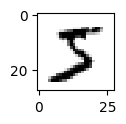

Tensor("cvae_1/encoder_1/z_mean_1/BiasAdd:0", shape=(1, 16), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step

Output Image:



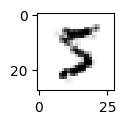


Example 1, Label: 0

Input Image:



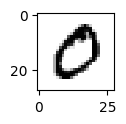

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Output Image:



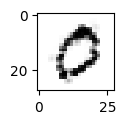


Example 2, Label: 4

Input Image:



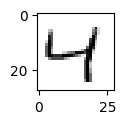

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Output Image:



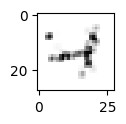


Example 3, Label: 1

Input Image:



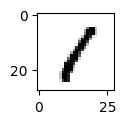

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Output Image:



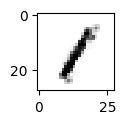


Example 4, Label: 9

Input Image:



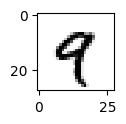

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Output Image:



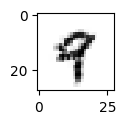


Example 5, Label: 2

Input Image:



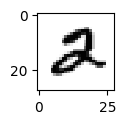

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Output Image:



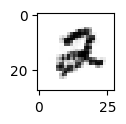


Example 6, Label: 1

Input Image:



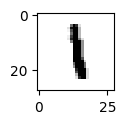

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Output Image:



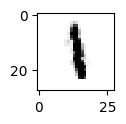


Example 7, Label: 3

Input Image:



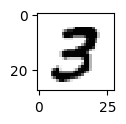

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Output Image:



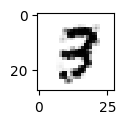


Example 8, Label: 1

Input Image:



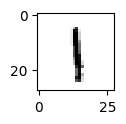

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Output Image:



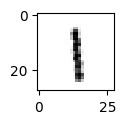


Example 9, Label: 4

Input Image:



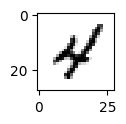

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

Output Image:



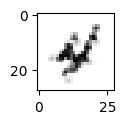

In [15]:
cvar_autoEncoder.setAutoEncoder(cvae)

for i in range(10):
    print(f"\nExample {i}, Label: {np.argmax(mnist_labels_onehot[i])}")
    cvar_autoEncoder.compareInputOutput(mnist_digits[i], mnist_labels_onehot[i])

### Trying a checkerboard image, with a label of 5


Input Image:



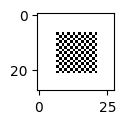

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Output Image:



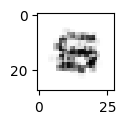

In [119]:
# Function for getting a number encoding label
def createLabelEncoding(num):
    encoding  = np.zeros(10)
    encoding[num] = 1
    return encoding

test_image = np.zeros((28, 28, 1), dtype=np.float32)

start_idx = 7  # (28 - 14) // 2
end_idx = 22   # start_idx + 14
box_size = 1

for i in range(start_idx, end_idx, box_size):
   for j in range(start_idx, end_idx, box_size):
       # If sum of indices is even, make it black (0)
       if ((i + j) // box_size) % 2 == 0:
           test_image[i:i+box_size, j:j+box_size] = 1

test_label = createLabelEncoding(5)
cvar_autoEncoder.compareInputOutput(test_image, test_label)  # Uses test_image but with the given input of 5



Overall, the Handwritten digit of the 5 is not super well done, and I think that this is due to the model not being trained in the best way. 
It takes over 20 minutes to train the model every time, so running hyperparameter tuning or more epochs is a time consuming task, and I am currently
content with the model's generation of it's own 5. I might come back later and work on this hyperparameter tuning and longer training time more. 


Image of a 5 with Label: 0

Input Image:



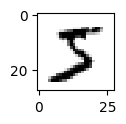

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Output Image:



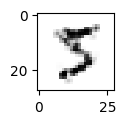


Image of a 5 with Label: 1

Input Image:



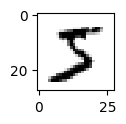

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Output Image:



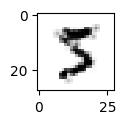


Image of a 5 with Label: 2

Input Image:



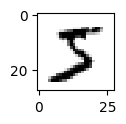

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Output Image:



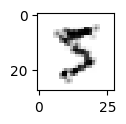


Image of a 5 with Label: 3

Input Image:



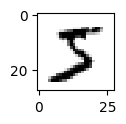

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

Output Image:



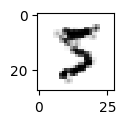


Image of a 5 with Label: 4

Input Image:



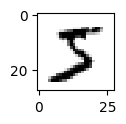

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Output Image:



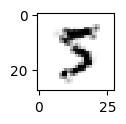


Image of a 5 with Label: 5

Input Image:



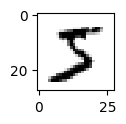

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Output Image:



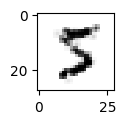


Image of a 5 with Label: 6

Input Image:



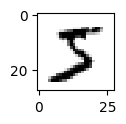

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Output Image:



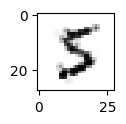


Image of a 5 with Label: 7

Input Image:



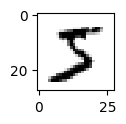

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Output Image:



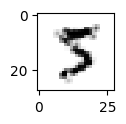


Image of a 5 with Label: 8

Input Image:



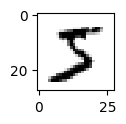

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Output Image:



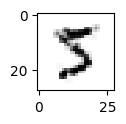


Image of a 5 with Label: 9

Input Image:



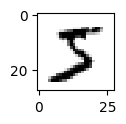

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Output Image:



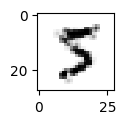

In [123]:
for i in range(10):
    print(f"\nImage of a 5 with Label: {i}")
    cvar_autoEncoder.compareInputOutput(mnist_digits[0], createLabelEncoding(i))

Overall, I think that this does not show too much, but again, I think that if I trained this model for considerably longer, than the outputs here would be more interesting

### Citations:

1) Building Autoencoders in Keras:
   https://blog.keras.io/building-autoencoders-in-keras.html

2) Variational AutoEncoder:
   https://keras.io/examples/generative/vae/

3) Stack Overflow
   https://stackoverflow.com/questions/51202181/how-do-i-select-only-a-specific-digit-from-the-mnist-dataset-provided-by-keras
   
4) Github
   https://ijdykeman.github.io/ml/2016/12/21/cvae.html